In [1]:
import numpy as np
import pandas as pd
import copy
import pylab
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from numpy import where
from sklearn.metrics import mean_squared_error, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.calibration import calibration_curve 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\himaj\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\himaj\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
dt = pd.read_csv('mortgage.csv')

last = dt.groupby('id').last()

dtsub = dt[dt['status_time']!=0]
dtsub.loc[:,'default'] = (dt.loc[:,'status_time']==1).astype(int)
dtsub.columns

Index(['id', 'time', 'orig_time', 'first_time', 'mat_time', 'balance_time',
       'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time',
       'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time',
       'investor_orig_time', 'balance_orig_time', 'FICO_orig_time',
       'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time',
       'default_time', 'payoff_time', 'status_time', 'default'],
      dtype='object')

In [3]:
dtsub.shape

(41747, 24)

In [4]:
dtsub.reset_index(drop=True, inplace=True)
dtsub.head()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time,default
0,1,48,-7,25,113,29087.21,26.658065,9.200,146.45,2.715903,...,0,45000.0,715,69.4,9.200,87.03,1,0,1,1
1,2,26,18,25,138,105654.77,65.469851,7.680,225.10,2.151365,...,0,107200.0,558,80.0,7.680,186.91,0,1,2,0
2,3,29,-6,25,114,44378.60,31.459735,11.375,217.37,1.692969,...,0,48600.0,680,83.6,8.750,89.58,0,1,2,0
3,5,27,18,25,138,52100.71,66.346343,9.155,222.39,2.361722,...,0,52800.0,527,80.0,9.155,186.91,0,1,2,0
4,6,56,19,25,139,190474.11,75.834755,6.580,181.43,1.717053,...,0,212000.0,670,80.0,6.580,191.42,1,0,1,1


In [5]:
print(np.where(dtsub['default_time']!=dtsub['default']))
#dtsub = dtsub.drop(columns = ['id','time','orig_time','first_time','mat_time','default_time'])
dtsub = dtsub.drop(columns = ['default_time'])

# censoring observations which have originated before the start of the observation period
# given the loans might have matured or borrowers refinanced
#dtsub = dtsub.drop(dtsub[dtsub.orig_time <= 0].index) 

(array([], dtype=int64),)


### Exploratory Data Analysis

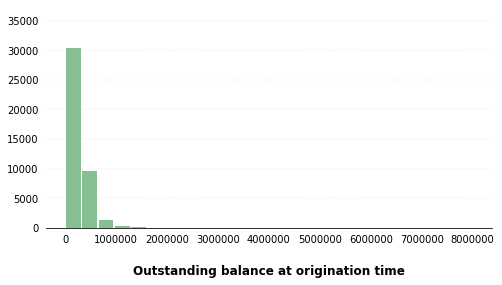

In [6]:
ax = dtsub.hist(column='balance_orig_time', bins=25, grid=False, figsize=(8,4), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]
for x in ax:
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    x.set_title("")
    x.set_xlabel("Outstanding balance at origination time", labelpad=20, weight='bold', size=12)

In [7]:
(dtsub['balance_orig_time']>2000000).sum()

22

In [8]:
dtsub[(dtsub['balance_orig_time']>2000000) & dtsub['default']==1]

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,payoff_time,status_time,default
6291,6948,34,26,26,184,7019196.39,103.626332,6.919,173.35,-0.314448,...,0,0,6500000.0,741,73.9,2.525,225.10,0,1,1
15848,18243,34,28,30,148,2064656.38,87.944304,7.875,173.35,-0.314448,...,1,0,2082500.0,680,70.0,7.875,219.67,0,1,1
28947,33772,46,23,28,144,2954054.33,70.351655,3.000,155.61,1.175909,...,1,0,3000000.0,779,50.1,5.500,221.91,0,1,1
32512,38026,47,30,32,150,2727697.84,110.814331,6.875,149.58,1.668182,...,1,0,2482000.0,731,70.9,6.875,212.73,0,1,1
32695,38253,47,27,29,187,2325748.21,86.445906,2.000,149.58,1.668182,...,1,0,2400000.0,625,60.0,2.150,222.39,0,1,1
34359,40149,45,17,22,118,2705386.81,69.507071,2.750,154.87,1.639155,...,1,0,2706000.0,795,60.0,4.125,179.45,0,1,1


- Removing the observations which look like outliers because even with high outstanding balance at the origination and observation times and with good FICO scores, 6 of the records still defaulted - This might be a data entry error

In [9]:
indices = dtsub[(dtsub['balance_orig_time']>2000000) & dtsub['default']==1].index 
dtsub.drop(indices, inplace=True)

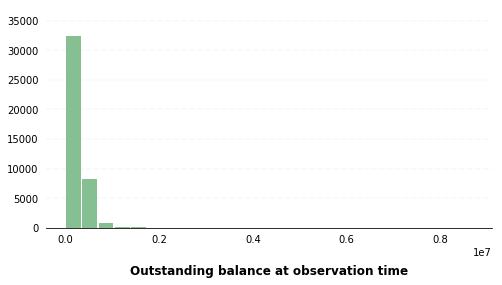

In [10]:
ax = dtsub.hist(column='balance_time', bins=25, grid=False, figsize=(8,4), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]
for x in ax:
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    x.set_title("")
    x.set_xlabel("Outstanding balance at observation time", labelpad=20, weight='bold', size=12)

In [11]:
(dtsub['balance_time']>2000000).sum() # 10 records with outstanding balance at observation time > 2000000

10

Text(0.5, 1.0, 'Distribution plot of FICO')

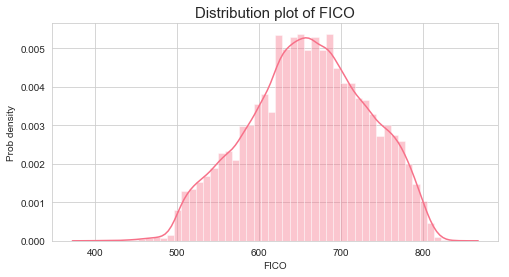

In [12]:
sns.set_palette("husl")
sns.set_style('whitegrid')
plt.figure(figsize=(8,4))
sns.distplot(dtsub['FICO_orig_time'])
plt.xlabel('FICO')
plt.ylabel('Prob density')
plt.title('Distribution plot of FICO',fontsize=15)

- Increasing percentages for FICO up to a value of almost 700 and then decreasing percentages, left skewed

In [13]:
print('Number of records with FICO<500: ',(dtsub['FICO_orig_time']<500).sum())
print('Number of records with FICO<500 and defaulted: ',len(dtsub[(dtsub['FICO_orig_time']<500) & dtsub['default']==1]))

Number of records with FICO<500:  211
Number of records with FICO<500 and defaulted:  117


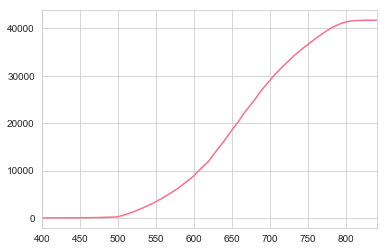

In [14]:
cdf = dtsub['FICO_orig_time'].value_counts().sort_index().cumsum()
cdf.plot()

- PDF: is used to specify the probability of the random variable falling within a particular range of values, as opposed to taking on any one value
- CDF: In the case of a scalar continuous distribution, it gives the area under the probability density function from minus infinity to x. Cumulative distribution functions are also used to specify the distribution of multivariate random variables.
- Starts at 0% to the left and end at 100% to the right
- CDF looks almost continuous, because the variable being continuous 

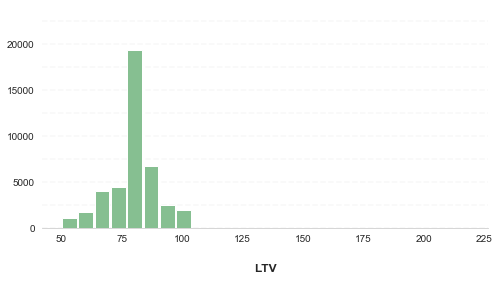

In [15]:
ax = dtsub.hist(column='LTV_orig_time', bins=25, grid=False, figsize=(8,4), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]
for x in ax:
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    x.set_title("")
    x.set_xlabel("LTV", labelpad=20, weight='bold', size=12)

- Similar values have a rather high relative frequency compared to others, particular the value of 80. This might be because LTV is the ratio of the outstanding loan amount to the collateral value, and banks traditionally extend loans in the region of 80 percent.

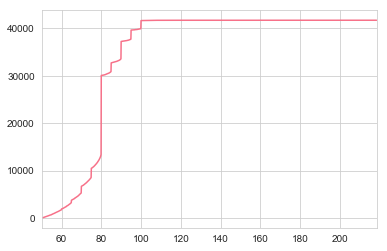

In [16]:
cdf = dtsub['LTV_orig_time'].value_counts().sort_index().cumsum()
cdf.plot()

- Starts at 0% to the left and end at 100% to the right
- There are discontinuity points where there are high relative frequencies

- Q-Q Plot
    - Quantiles can be used for a graphical comparison with standard distributions, such as a normal distribution. The normal distribution is widely used in applications and is a symmetric distribution with a single mode. A quantile-quantile (Q-Q) plot compares for each value its quantile value with the theoretical value under a specific distribution. Here we use the normal distribution with the same mean and standard deviation as the empirical data. If the data were from a normal distribution, both the empirical and the theoretical quantiles should be roughly equal and lie on the diagonal line.

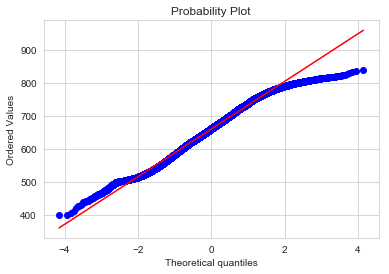

In [17]:
stats.probplot(dtsub['FICO_orig_time'], dist="norm", plot=pylab)
pylab.show()

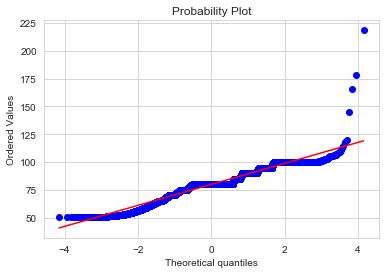

In [18]:
stats.probplot(dtsub['LTV_orig_time'], dist="norm", plot=pylab)
pylab.show()

- There are divergences for FICO and LTV, particularly for extreme observations, which signals that the empirical data have different tails than the theoretical normal distribution

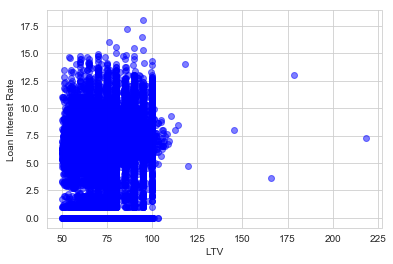

In [19]:
plt.scatter(dtsub['LTV_orig_time'], dtsub['Interest_Rate_orig_time'],c='blue', alpha=0.5) 
plt.xlabel("LTV") 
plt.ylabel("Loan Interest Rate")
plt.show()

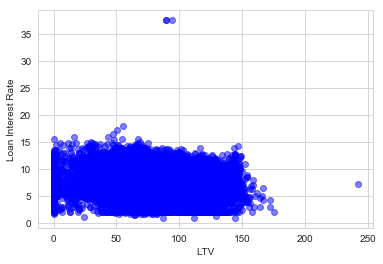

In [20]:
plt.scatter(dtsub['LTV_time'], dtsub['interest_rate_time'],c='blue', alpha=0.5) 
plt.xlabel("LTV") 
plt.ylabel("Loan Interest Rate")
plt.show()

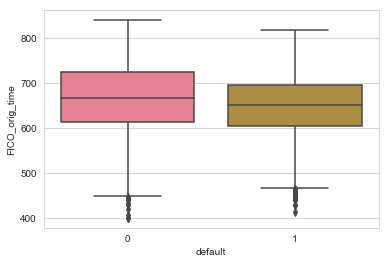

In [21]:
sns.boxplot(x = 'default', y = 'FICO_orig_time', data = dtsub)

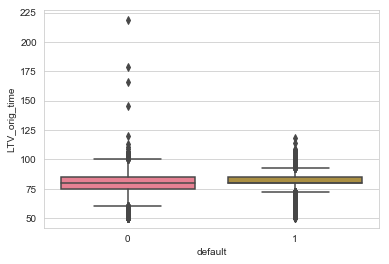

In [22]:
sns.boxplot(x = 'default', y = 'LTV_orig_time', data = dtsub)

- The location of the box is higher for FICO and lower for LTV in the nondefault category compared to the default category, which shows some interrelation between the variables in the sense that higher FICO scores correspond to a lower default frequency and higher LTVs correspond to a higher default frequency.

##### Correlation Matrix 

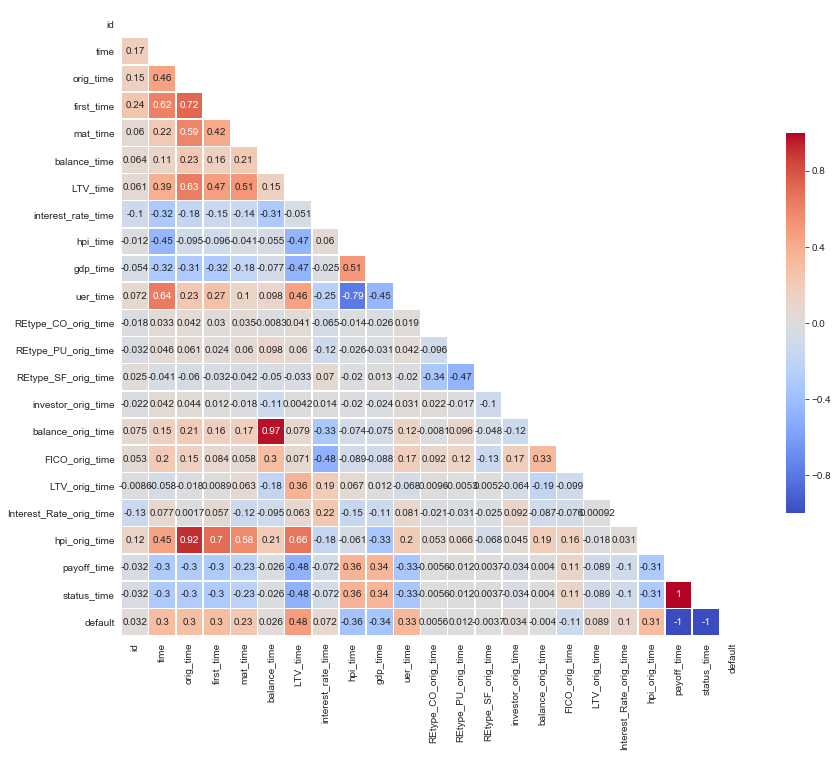

In [23]:
corr = dtsub.corr()
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize = (14, 14))
cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(corr, mask = mask, ax = ax, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

### Data Preprocessing 

##### Missing Values 

In [24]:
dtsub.isnull().sum()

id                          0
time                        0
orig_time                   0
first_time                  0
mat_time                    0
balance_time                0
LTV_time                   12
interest_rate_time          0
hpi_time                    0
gdp_time                    0
uer_time                    0
REtype_CO_orig_time         0
REtype_PU_orig_time         0
REtype_SF_orig_time         0
investor_orig_time          0
balance_orig_time           0
FICO_orig_time              0
LTV_orig_time               0
Interest_Rate_orig_time     0
hpi_orig_time               0
payoff_time                 0
status_time                 0
default                     0
dtype: int64

In [25]:
dtsub = dtsub.dropna(how='any',axis=0)

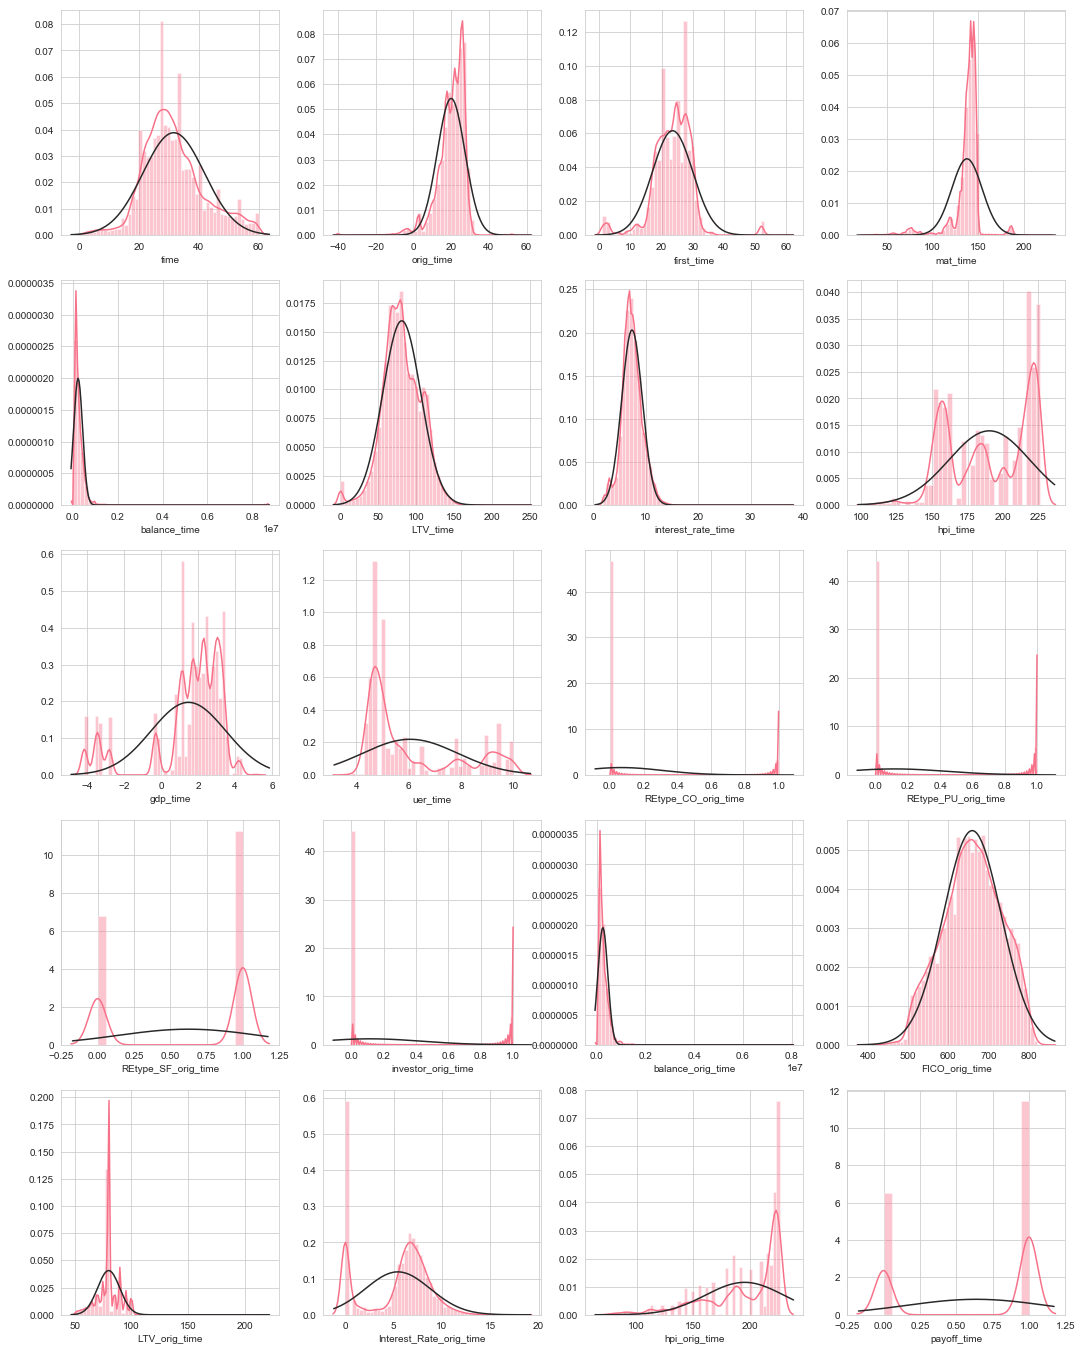

In [270]:
fig,axes = plt.subplots(5,4,figsize=(18,24))
for i,col in enumerate(dtsub.columns[1:21]): sns.distplot(dtsub[col],fit=norm,ax=axes[i//4,i%4])

#### One-hot encoding

In [26]:
dtsub['default'].value_counts()

0    26582
1    15147
Name: default, dtype: int64

In [27]:
dtsub['status_time'].value_counts()

2    26582
1    15147
Name: status_time, dtype: int64

In [28]:
dtsub['payoff_time'].value_counts()

1    26582
0    15147
Name: payoff_time, dtype: int64

In [29]:
data = dtsub.copy()
data = data.drop(columns = ['id', 'status_time', 'payoff_time'])

- default, status and payoff are all talking about the same thing whether the customer defaulted or not, so dropping status and payoff to make sure there is no multicollinearity

In [30]:
data.dtypes

time                         int64
orig_time                    int64
first_time                   int64
mat_time                     int64
balance_time               float64
LTV_time                   float64
interest_rate_time         float64
hpi_time                   float64
gdp_time                   float64
uer_time                   float64
REtype_CO_orig_time          int64
REtype_PU_orig_time          int64
REtype_SF_orig_time          int64
investor_orig_time           int64
balance_orig_time          float64
FICO_orig_time               int64
LTV_orig_time              float64
Interest_Rate_orig_time    float64
hpi_orig_time              float64
default                      int32
dtype: object

In [31]:
#data2 = data[['id','default']]
data = data.drop(columns=['REtype_CO_orig_time','REtype_PU_orig_time','REtype_SF_orig_time','investor_orig_time', 'default'])
# Data Transformation
data = (data-data.min())/(data.max()-data.min())
data.head()

,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time
0,0.796610,0.33,0.40678,0.436893,0.003348,0.110088,0.224658,0.326017,0.739572,0.725806,0.004848,0.715909,0.114608,0.511111,0.075176
1,0.423729,0.58,0.40678,0.558252,0.012161,0.270366,0.183014,0.989954,0.678732,0.145161,0.012629,0.359091,0.177553,0.426667,0.738478
2,0.474576,0.34,0.40678,0.441748,0.005108,0.129917,0.284247,0.924700,0.629332,0.112903,0.005298,0.636364,0.198931,0.486111,0.092111
3,0.440678,0.58,0.40678,0.558252,0.005997,0.273985,0.223425,0.967077,0.701402,0.096774,0.005824,0.288636,0.177553,0.508611,0.738478
4,0.932203,0.59,0.40678,0.563107,0.021924,0.313169,0.152877,0.621307,0.631927,0.451613,0.025739,0.613636,0.177553,0.365556,0.768429


In [32]:
object_data = dtsub[['REtype_CO_orig_time','REtype_PU_orig_time','REtype_SF_orig_time','investor_orig_time']]
object_data = object_data.astype(object)
w = object_data.copy()
w = w.replace({'REtype_CO_orig_time':0},'Not_Condominium')
w = w.replace({'REtype_CO_orig_time':1},'Condominium')
w = w.replace({'REtype_PU_orig_time':0},'Not_Urban_dev')
w = w.replace({'REtype_PU_orig_time':1},'Urban_dev')
w = w.replace({'REtype_SF_orig_time':0},'Not_Single_family_home')
w = w.replace({'REtype_SF_orig_time':1},'Single_family_home')
w = w.replace({'investor_orig_time':0},'Not_Borrower')
w = w.replace({'investor_orig_time':1},'Borrower')
w.head()

,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time
0,Not_Condominium,Not_Urban_dev,Single_family_home,Not_Borrower
1,Not_Condominium,Not_Urban_dev,Single_family_home,Not_Borrower
2,Not_Condominium,Not_Urban_dev,Single_family_home,Not_Borrower
3,Not_Condominium,Not_Urban_dev,Single_family_home,Not_Borrower
4,Not_Condominium,Not_Urban_dev,Single_family_home,Not_Borrower


In [33]:
obj_data = pd.get_dummies(w, prefix=['CO', 'PU', 'SF','Investor'])
obj_data.head()

,CO_Condominium,CO_Not_Condominium,PU_Not_Urban_dev,PU_Urban_dev,SF_Not_Single_family_home,SF_Single_family_home,Investor_Borrower,Investor_Not_Borrower
0,0,1,1,0,0,1,0,1
1,0,1,1,0,0,1,0,1
2,0,1,1,0,0,1,0,1
3,0,1,1,0,0,1,0,1
4,0,1,1,0,0,1,0,1


In [34]:
new_data = pd.concat([data,obj_data,dtsub['default']],axis=1)
new_data.head()

,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,...,hpi_orig_time,CO_Condominium,CO_Not_Condominium,PU_Not_Urban_dev,PU_Urban_dev,SF_Not_Single_family_home,SF_Single_family_home,Investor_Borrower,Investor_Not_Borrower,default
0,0.796610,0.33,0.40678,0.436893,0.003348,0.110088,0.224658,0.326017,0.739572,0.725806,...,0.075176,0,1,1,0,0,1,0,1,1
1,0.423729,0.58,0.40678,0.558252,0.012161,0.270366,0.183014,0.989954,0.678732,0.145161,...,0.738478,0,1,1,0,0,1,0,1,0
2,0.474576,0.34,0.40678,0.441748,0.005108,0.129917,0.284247,0.924700,0.629332,0.112903,...,0.092111,0,1,1,0,0,1,0,1,0
3,0.440678,0.58,0.40678,0.558252,0.005997,0.273985,0.223425,0.967077,0.701402,0.096774,...,0.738478,0,1,1,0,0,1,0,1,0
4,0.932203,0.59,0.40678,0.563107,0.021924,0.313169,0.152877,0.621307,0.631927,0.451613,...,0.768429,0,1,1,0,0,1,0,1,1


- Logit

In [35]:
model = smf.logit('default~(FICO_orig_time+LTV_orig_time+gdp_time)',data=new_data).fit()
#model = smf.logit('default~1',data=dtsub).fit()

Optimization terminated successfully.
         Current function value: 0.580846
         Iterations 5


In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                41729
Model:                          Logit   Df Residuals:                    41725
Method:                           MLE   Df Model:                            3
Date:                Thu, 30 Apr 2020   Pseudo R-squ.:                  0.1134
Time:                        10:10:20   Log-Likelihood:                -24238.
converged:                       True   LL-Null:                       -27337.
                                        LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.1902      0.067     32.598      0.000       2.059       2.322
FICO_orig_time    -1.9878      0.069    -28.893      0.000      -2.123      -1.853
LTV_orig_time      3.4019      0.194     17.544      0.000       3.022       3.782
gdp_time          -3.6779      0.055    -66.510      0.000      -3.786      -3.570
==================================================================================
"""

In [37]:
(new_data['default']==(model.predict(new_data)>0.5).astype(int)).mean() # Accuracy

0.6955115147738983

##### Train-Test Split

In [38]:
X = new_data.drop(columns = ['default'])
y = new_data['default']
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 42)
ytrain.value_counts()

0    18702
1    10508
Name: default, dtype: int64

##### Data Imbalance

In [39]:
sm = SMOTE(ratio='auto')
xtrain_ba, ytrain_bal = sm.fit_sample(xtrain, ytrain)
xtrain_bal = pd.DataFrame(xtrain_ba, columns = xtrain.columns)
xtrain_bal.shape

(37404, 23)

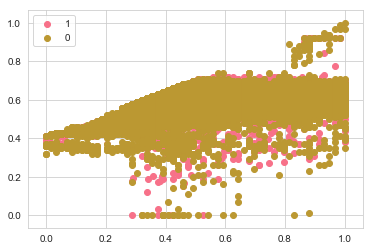

In [40]:
counter = Counter(ytrain_bal) # Counter({1: 18702, 0: 18702})
for label, _ in counter.items():
    row_ix = where(ytrain_bal == label)[0]
    pyplot.scatter(xtrain_ba[row_ix, 0], xtrain_ba[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

### Logistic Regression for Defaults

In [41]:
clf_logistic = LogisticRegression(solver = 'lbfgs')
clf_logistic.fit(xtrain_bal, ytrain_bal)
print(clf_logistic.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [42]:
print(clf_logistic.intercept_)

[-0.7909195]


In [43]:
print(clf_logistic.coef_)

[[ 1.78908057 -3.08829694  2.00648708  1.59445729  0.76168285 12.63552759
   3.60249438 -0.6760079  -0.7989206  -0.25184732 -1.04778189 -3.06776547
  -3.7990566   0.34163638 -0.52935142 -0.2772418  -0.22746234 -0.25574133
  -0.24896282 -0.21592977 -0.28877438 -0.01753453 -0.48716962]]


In [44]:
preds = clf_logistic.predict_proba(xtest)

In [45]:
# first five predictions and true labels
preds_df = pd.DataFrame(preds[:,1][0:5], columns = ['prob_default'])
true_df = ytest.head()

print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

   default  prob_default
0        0      0.085314
1        1      0.854531
2        1      0.368032
3        0      0.450483
4        0      0.126386


In [46]:
accuracy = clf_logistic.score(xtest,ytest)
print('accuracy: ', accuracy)

accuracy:  0.7710679766754533


- ROC curve charts (Receiver Operating Characteristic Curve)
    - They plot the true positive rate(sensitivity), the percentage of correctly predicted defaults, against the false positive rate(fall-out), the percentage of incorrectly predicted defaults

- The dotted line represents the random prediction and the curve represents the model's predictions
- ROC charts are interpreted by looking at how far away the model's curve gets from the dotted line which predicts the random prediction. This movement away from the line is called lift
    - The more lift we have, the larger the area under the curve gets
    - The AUC is the calculated area between the curve and the random prediction. This is a direct indicator of how well the model makes predictions

- To analyze the performance further, we need to decide what probability range is a default and what is a non-default
    - Let's say that we decide any probability over 0.5 as a default, and anything below that is a non-default. What this means is that we will assigne a new loan status to these loans based on their probabilty of default and the threshold. Once we have this, we can further check the model's performance.
    - Once the threshold is defined, we need to relabel our loans based on that threshold

In [47]:
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

print(preds_df['loan_status'].value_counts())

target_names = ['Non-Default', 'Default']
print(classification_report(ytest, preds_df['loan_status'], target_names=target_names))

0    7394
1    5125
Name: loan_status, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.84      0.79      0.81      7880
     Default       0.67      0.74      0.71      4639

    accuracy                           0.77     12519
   macro avg       0.76      0.77      0.76     12519
weighted avg       0.78      0.77      0.77     12519



- Another useful function for evaluating model's performance is the classification report function. 
- There are two really useful metrics in this table, and they are precison and recall
- Sometimes after generating the report, we want to select or store specific values from within the report 
    - precision-recall-fscore support function
    - with this function, we can get the recall for defaults by subsetting the report the way we would any array

In [48]:
print(precision_recall_fscore_support(ytest,preds_df['loan_status']))

(array([0.8390587 , 0.67297561]), array([0.78730964, 0.7434792 ]), array([0.81236087, 0.70647276]), array([7880, 4639], dtype=int64))


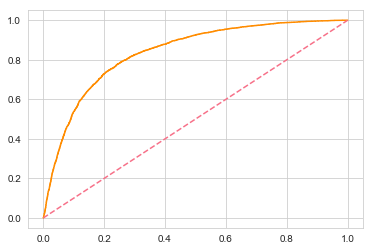

AUC:  0.8372428965195762


In [49]:
fallout, sensitivity, thresholds = roc_curve(ytest, preds_df['prob_default'])
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

auc = roc_auc_score(ytest, preds_df['prob_default'])
print('AUC: ', auc)

- Another way to analyze the model's performace is with the confusion matrix. These will show all of the correct and incorrect predictions for loan status
        - TN                FP
        - Pred=0,Actual=0   Pred=1,Actual=0
        - FN                TP
        - Pred=0,Actual=1   Pred=1,Actual=1
        
        - Precision(0) = TN/(TN+FN)     Precision(1) = TP/(TP+FP)
        - Recall(0) = TN/(TN+FP)        Recall(1) = TP/(TP+FN)

In [50]:
print(confusion_matrix(ytest, preds_df['loan_status'])) # recall = 0.75

[[6204 1676]
 [1190 3449]]


In [51]:
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)
print(confusion_matrix(ytest, preds_df['loan_status'])) # recall = 0.83

[[5500 2380]
 [ 807 3832]]


In [52]:
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.3 else 0)
print(confusion_matrix(ytest, preds_df['loan_status'])) # recall = 0.899

[[4458 3422]
 [ 473 4166]]


- Recall for default = 0.68, the proportion of true defaults predicted by our model is 68%

- Imagine that we have 50,000 loans in our portfolio, and they each have a total loan amount of 50 dollars
        - defaults predicted/not predicted = 0.68/0.32
        - Estimated loss = (50000*0.32)*50 = 800,000 dollars
- If all of our true default loans defaulted right now, our estimated loss from the portfolio would be 800,000 dollars. This loss would be something we didn't plan for, and would be unexpected

In [53]:
def_recalls = []
nondef_recalls = []
accs = []
thresh = [0.2,0.225,0.25,0.275,0.3,0.325,0.35,0.375,0.4,0.425,0.45,0.475,0.5,0.525,0.55,0.575,0.6,0.625,0.65]
for i in thresh:
    preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > i else 0)
    def_recalls.append(precision_recall_fscore_support(ytest,preds_df['loan_status'])[1][1])
    nondef_recalls.append(precision_recall_fscore_support(ytest,preds_df['loan_status'])[1][0])
    accs.append(classification_report(ytest, preds_df['loan_status'], target_names=target_names, output_dict=True)['macro avg']['recall'])

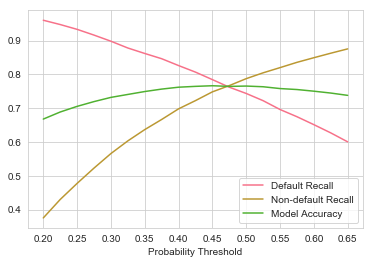

In [54]:
ticks = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel('Probability Threshold')
plt.xticks(ticks)
plt.legend(['Default Recall','Non-default Recall','Model Accuracy'])
plt.show()

- When it comes to precision, recall and accuracy it can be challenging to find an optimum number for all three as target
- Consider the graph of the logistic regression model on the credit data
    - The default recall, starts out really high. This is because if we predict all loans to be a default, we definitely predict all of our defaults correctly!
    - Also, when the default recall is high, more often than not non-default recall is low
- We have to make a determination about what scores for each are good enough in order to set a baseline for performance

        - Here in this case, 0.475 threshold would maximize the scores evenly

In [55]:
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.475 else 0)
print(confusion_matrix(ytest, preds_df['loan_status']))
preds_df_logistic = preds_df
target_names = ['Non-Default', 'Default']
print(classification_report(ytest, preds_df_logistic['loan_status'], target_names=target_names))

[[6042 1838]
 [1104 3535]]
              precision    recall  f1-score   support

 Non-Default       0.85      0.77      0.80      7880
     Default       0.66      0.76      0.71      4639

    accuracy                           0.76     12519
   macro avg       0.75      0.76      0.76     12519
weighted avg       0.78      0.76      0.77     12519



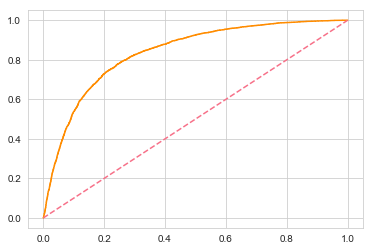

AUC:  0.8372428965195762


In [56]:
fallout, sensitivity, thresholds = roc_curve(ytest, preds_df_logistic['prob_default'])
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

auc = roc_auc_score(ytest, preds_df_logistic['prob_default'])
print('AUC: ', auc)

In [151]:
true_df = ytest
true_df = pd.concat([true_df.reset_index(drop = True), preds_df_logistic], axis = 1)
true_df.head()

,default,prob_default,loan_status
0,0,0.085314,0
1,1,0.854531,1
2,1,0.368032,0
3,0,0.450483,0
4,0,0.126386,0


### Gradient Boosted Trees using XGBoost 

In [58]:
clf_gbt = xgb.XGBClassifier()
clf_gbt.fit(xtrain_bal, ytrain_bal)
print(clf_logistic.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [59]:
preds = clf_gbt.predict_proba(xtest)

In [60]:
# first five predictions and true labels
preds_df = pd.DataFrame(preds[:,1][0:5], columns = ['prob_default'])
true_df = ytest.head()

print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

   default  prob_default
0        0      0.012106
1        1      0.759971
2        1      0.393835
3        0      0.743120
4        0      0.099814


In [61]:
gbt_preds = clf_gbt.predict(xtest)
target_names = ['Non-Default', 'Default']
print(classification_report(ytest, gbt_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.83      0.84      0.84      7880
     Default       0.73      0.72      0.72      4639

    accuracy                           0.79     12519
   macro avg       0.78      0.78      0.78     12519
weighted avg       0.79      0.79      0.79     12519



In [62]:
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

{'LTV_time': 396, 'FICO_orig_time': 407, 'time': 210, 'interest_rate_time': 322, 'uer_time': 124, 'balance_time': 357, 'balance_orig_time': 247, 'Interest_Rate_orig_time': 259, 'first_time': 230, 'orig_time': 149, 'LTV_orig_time': 277, 'SF_Not_Single_family_home': 37, 'mat_time': 215, 'hpi_time': 153, 'hpi_orig_time': 115, 'gdp_time': 193, 'Investor_Borrower': 22, 'PU_Not_Urban_dev': 23, 'CO_Condominium': 14}


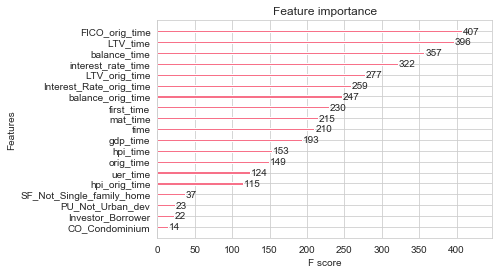

In [63]:
xgb.plot_importance(clf_gbt, importance_type = 'weight')
plt.show()

- Sometimes adding more columns increases accuracy, but it can also make it more difficult for the model to learn and decrease other performance metrics like default recall
- It can be difficult to use two metrics like accuracy and recall to guage a model's performance
- F1-score can be used which is a combination of both precision and recall
            - F1-score = 2*[(precision*recall)/(precision+recall)]
- This is useful because it helps keep recall for loan defaults as an important consideration for any model

In [64]:
xtrain_bal2 = xtrain_bal[['LTV_time','FICO_orig_time','balance_time','interest_rate_time','LTV_orig_time','Interest_Rate_orig_time','time','first_time','balance_orig_time','mat_time','orig_time','gdp_time','hpi_time','uer_time','hpi_orig_time']]
xtest2 = xtest[['LTV_time','FICO_orig_time','balance_time','interest_rate_time','LTV_orig_time','Interest_Rate_orig_time','time','first_time','balance_orig_time','mat_time','orig_time','gdp_time','hpi_time','uer_time','hpi_orig_time']]

In [65]:
clf_gbt2 = xgb.XGBClassifier()
clf_gbt2.fit(xtrain_bal2, ytrain_bal)
preds2 = clf_gbt2.predict_proba(xtest2)

gbt_preds2 = clf_gbt2.predict(xtest2)
target_names = ['Non-Default', 'Default']
print(classification_report(ytest, gbt_preds2, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.84      0.84      0.84      7880
     Default       0.72      0.72      0.72      4639

    accuracy                           0.79     12519
   macro avg       0.78      0.78      0.78     12519
weighted avg       0.79      0.79      0.79     12519



- Not much difference in the scores can be seen even after excluding the features that didn't have much importance, except recall has improved
- f1-score for predicting defaults is highest for the second model with important features

In [66]:
xtrain_bal3 = xtrain_bal[['LTV_time','FICO_orig_time','balance_time','interest_rate_time','LTV_orig_time','Interest_Rate_orig_time']]
xtest3 = xtest[['LTV_time','FICO_orig_time','balance_time','interest_rate_time','LTV_orig_time','Interest_Rate_orig_time']]

In [67]:
clf_gbt3 = xgb.XGBClassifier()
clf_gbt3.fit(xtrain_bal3, ytrain_bal)
preds3 = clf_gbt3.predict_proba(xtest3)

gbt_preds3 = clf_gbt3.predict(xtest3)
target_names = ['Non-Default', 'Default']
print(classification_report(ytest, gbt_preds3, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.84      0.81      0.82      7880
     Default       0.69      0.73      0.71      4639

    accuracy                           0.78     12519
   macro avg       0.76      0.77      0.77     12519
weighted avg       0.78      0.78      0.78     12519



- In the case of 3rd model, f1-score reduced
- Overall, 2nd model seems to be the best model

- The models have parameters that are like settings that affect how a model learns. These settings are called hyperparameters
- Hyperparameters cannot be learned from data; they have to be set by us. 
    - The learning rate tells the model how quickly it should learn in each step of the ensemble. The smaller the value, the more conservative it is at each step
    - The max_depth tells the model how deep each tree can go. Keeping this value ensures the model is not too complex

- As we select different hyperparameters and columns for our models, to know that they will perform better over time, we use cross-validation to test our models to see how they might perform after we implement them
- Cross-Validation: a method for training and testing a model multiple times on the same data
- We cannot create more loan data to help us develop our model, but we can use cross-validation to simulate how our model will perform on new loan data before it comes in
- Cross Validation
    - Take the entire set of training data and create pieces, called folds, from it
    - All but one of the folds are used for training, and the remaining fold is used as a kind of miniature test set
    - Once testing on all folds is completed, the model is tested against the actual test set
        - Suppose the number of folds is 5, the model is trained on 4 of the folds, and tested against the final fold. This process repeats through 5 splits so that each fold is used for testing at least once. Once this is done, the parameters are averaged across each training session and then the model is finally tested against the original test set 

- First we set the number of folds. Then, we set the number of iterations we will allow before the simulations stop. Next, we create a dictionary of parameters
    - The binary logistic parameter we created tells xgboost that we want to predict a 0 or 1 for loan status
    - The performance metric, area under the curve, the same metric used on the logistic regression models
- After creating the dictionary of parameters, training data is transformed into specialized dmatrix object for xgboost
- cv function is called and the data is passed along with the parameters dictionary

In [68]:
n_folds = 5
early_stopping = 10
params = {'eval_metric': 'auc', 'objective': 'binary:logistic', 'seed': 123}
DTrain = xgb.DMatrix(xtrain_bal2, label = ytrain_bal)
cv_df = xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds,early_stopping_rounds=early_stopping)
print(cv_df)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.859457       0.001456       0.849463      0.003332
1        0.869554       0.001940       0.858913      0.003448
2        0.876404       0.001515       0.864491      0.003799
3        0.881384       0.000954       0.869139      0.004640
4        0.885952       0.001046       0.872852      0.004418


- AUC for both train-auc-mean and test-auc-mean improves at each iteration of cross-validation. As the iterations progress the scores are getting better

In [69]:
cv = xgb.cv(params, DTrain, num_boost_round = 500, nfold=10, shuffle=True)
# Mean of the test AUC scores
print('Mean of the test AUC scores: ',round(np.mean(cv['test-auc-mean']),2))

Mean of the test AUC scores:  0.92


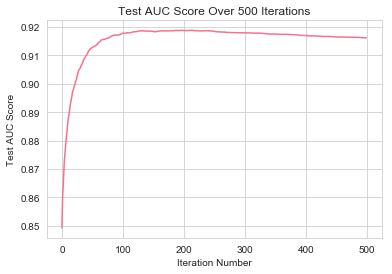

In [70]:
plt.plot(cv['test-auc-mean'])
plt.title('Test AUC Score Over 500 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

- Test AUC scores never reaches 1 and begins to slightly decrease after 100 iterations. This might be because of over-fitting

In [71]:
# Cross validation scoring - cross_val_score()
# Used to automatically perform cross-validation with data splitting, model training, and scoring all at once

gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7)

cv_scores = cross_val_score(gbt, xtrain_bal2, ytrain_bal, cv = 10) # produces a df of training and test AUC scores

print(cv_scores) # # The result is an array of scores for each iteration of training and scoring

print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

[0.79262427 0.78220203 0.79679144 0.79117647 0.78609626 0.82994652
 0.87807487 0.85882353 0.87807487 0.8828877 ]
Average accuracy: 0.83 (+/- 0.08)


- Model accuracy is increased form 78% to 83% through cross-validation

##### Hyperparameter tuning with XGBoost

In [78]:
model_xgb = xgb.XGBClassifier()
n_estimators = range(50, 400, 50)
max_depth = range(3,10)
#eta = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ]
#gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ] # helps prevent overfitting
#colsample_bytree = [ 0.3, 0.4, 0.5 , 0.7 ]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
# gamma=gamma, eta=eta, colsample_bytree=colsample_bytree
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model_xgb, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(xtrain_bal2, ytrain_bal)
grid_result

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=N...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=Fal

Best: -0.359643 using {'max_depth': 4, 'n_estimators': 300}
-0.416903 (0.007110) with: {'max_depth': 3, 'n_estimators': 50}
-0.387468 (0.007175) with: {'max_depth': 3, 'n_estimators': 100}
-0.375336 (0.007164) with: {'max_depth': 3, 'n_estimators': 150}
-0.367863 (0.007074) with: {'max_depth': 3, 'n_estimators': 200}
-0.364214 (0.007231) with: {'max_depth': 3, 'n_estimators': 250}
-0.361782 (0.007589) with: {'max_depth': 3, 'n_estimators': 300}
-0.360527 (0.007493) with: {'max_depth': 3, 'n_estimators': 350}
-0.394298 (0.007132) with: {'max_depth': 4, 'n_estimators': 50}
-0.373561 (0.006076) with: {'max_depth': 4, 'n_estimators': 100}
-0.365327 (0.007170) with: {'max_depth': 4, 'n_estimators': 150}
-0.361516 (0.006489) with: {'max_depth': 4, 'n_estimators': 200}
-0.360166 (0.006508) with: {'max_depth': 4, 'n_estimators': 250}
-0.359643 (0.006407) with: {'max_depth': 4, 'n_estimators': 300}
-0.360333 (0.006019) with: {'max_depth': 4, 'n_estimators': 350}
-0.383778 (0.007515) with: {'max

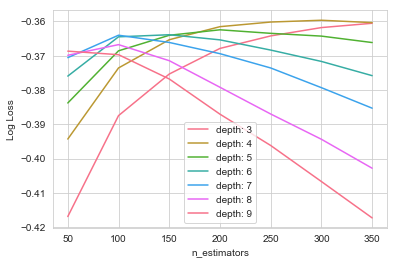

In [94]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_max_depth.png')

- The best score was observed for max_depth=4 and n_estimators=300 

In [95]:
gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 4, n_estimators = 300)
cv_scores = cross_val_score(gbt, xtrain_bal2, ytrain_bal, cv = 10)
print(cv_scores)
print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

[0.79208979 0.77819348 0.79385027 0.78502674 0.7815508  0.82834225
 0.88770053 0.87139037 0.89224599 0.88823529]
Average accuracy: 0.83 (+/- 0.09)


In [134]:
gbt.fit(xtrain_bal2, ytrain_bal)
preds_gbt = gbt.predict_proba(xtest2)
preds_gbt = [i[1] for i in preds_gbt]
preds2_gbt = gbt.predict(xtest2)
target_names = ['Non-Default', 'Default']
print(classification_report(ytest, preds2_gbt, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.84      0.83      0.84      7880
     Default       0.72      0.73      0.73      4639

    accuracy                           0.80     12519
   macro avg       0.78      0.78      0.78     12519
weighted avg       0.80      0.80      0.80     12519



### Model Evaluation and Implementation 

##### Classification Reports 

In [75]:
print(classification_report(ytest, preds_df_logistic['loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.85      0.77      0.80      7880
     Default       0.66      0.76      0.71      4639

    accuracy                           0.76     12519
   macro avg       0.75      0.76      0.76     12519
weighted avg       0.78      0.76      0.77     12519



In [97]:
print(classification_report(ytest, preds2_gbt, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.84      0.83      0.84      7880
     Default       0.72      0.73      0.73      4639

    accuracy                           0.80     12519
   macro avg       0.78      0.78      0.78     12519
weighted avg       0.80      0.80      0.80     12519



##### ROC Curves 

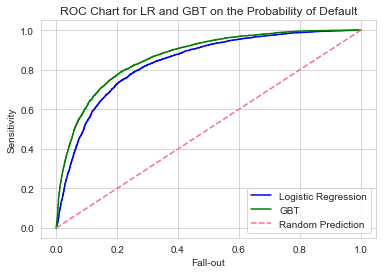

In [135]:
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(ytest, preds_df_logistic['prob_default'])
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(ytest, preds_gbt)

plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [136]:
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(ytest, preds_df_logistic['prob_default']))

print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(ytest, preds_gbt))

Logistic Regression AUC Score: 0.84
Gradient Boosted Tree AUC Score: 0.87


##### Calibration curve  

- Another method to compare models is to check how well calibrated their predicted probabilities are. What this means is we want to be able to interpret these probabilities as a confidence level for default
- A model is well calibrated when a sample of loans has an average predicted probability of default close to that sample's percentage of actual defaults
    - Example, if we take 10 loans and their average predicted probability of default is 0.12, then we expect 12% of the sample to be defaults
    - If the model has an average predicted probabilty of default of 0.25 and that sample is 65% defaults, then we have several loans that we predicted to be non-default that are actually defaults which are very costly
- To calculate these values we will use the calibration curve function
    - The result plots all the average predicted probabilities against all the percentage of actual defaults for each sample
        - When the model is above the perfectly calibrated line
                - Eg: PD=0.56, % of default=0.75, In this event, the average predicted probability of default was 0.56, but this sample contains 75% defaults. Here is where we find the majority of false negatives, which are quite costly. Model is having a difficult time accurately predicting the probability of default for the loans in this sample
        - When the model is below the perfectly calibrated line
                - Eg: PD=0.94, % of default=0.66, In this event, the average predicted probability of default was 0.94, but this sample contains 66% defaults. Here is where we find the majority of false positives. These are missed opportunities for profit, but are not as damaging as the false negatives.

In [147]:
# Array 1 is fraction of positives
# Array 2 is average probability

frac_of_pos_lr = calibration_curve(ytest, preds_df_logistic['prob_default'], n_bins = 16)[0]
mean_pred_val_lr = calibration_curve(ytest, preds_df_logistic['prob_default'], n_bins = 16)[1]

frac_of_pos_gbt = calibration_curve(ytest, preds_gbt, n_bins = 16)[0]
mean_pred_val_gbt = calibration_curve(ytest, preds_gbt, n_bins = 16)[1]

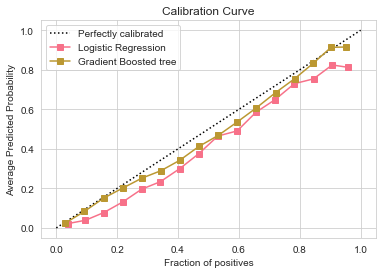

In [148]:
# Create the calibration curve plot with the guideline
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated') 
plt.plot(mean_pred_val_lr, frac_of_pos_lr, 's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,'s-', label='%s' % 'Gradient Boosted tree')
plt.xlabel('Fraction of positives')
plt.ylabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

- For GBT, the calibration for probabilities starts off great but then becomes erratic as the average probability approaches 0.3, but the model eventually stabilizes

#### Credit Acceptance Rates 

In [248]:
preds_gbt_array = np.asarray(preds_gbt)
preds_df_gbt = pd.DataFrame(preds_gbt_array, columns = ['prob_default'])
true_def = ytest

test_pred_df = pd.concat([true_def.reset_index(drop = True), preds_df_gbt], axis = 1)

In [244]:
# Check the statistics of the probabilities of default
print(test_pred_df['prob_default'].describe())

# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(test_pred_df['prob_default'], 0.85)

# Apply acceptance rate threshold
test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

print(test_pred_df['pred_loan_status'].value_counts())

count    12519.000000
mean         0.394302
std          0.309044
min          0.000068
25%          0.103022
50%          0.321755
75%          0.695794
max          0.983730
Name: prob_default, dtype: float64
0    10641
1     1878
Name: pred_loan_status, dtype: int64


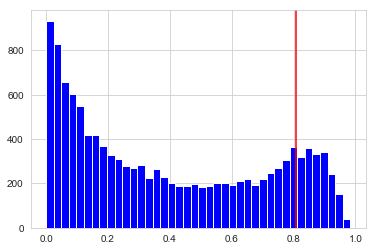

In [245]:
plt.hist(preds_gbt, color = 'blue', bins = 40) # plot of predicted probabilities of default

# Calculating the threshold with quantile
threshold = np.quantile(preds_gbt, 0.85)

# Adding a reference line to the plot for the threshold
plt.axvline(x = threshold, color = 'red')
plt.show()

- Here, we can see where the threshold is on the range of predicted probabilities. Not only can we see how many loans will be accepted (left side), but also how many loans will be rejected (right side)

In [246]:
# Create a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# Calculate the bad rate
print(np.sum(accepted_loans['default']) / accepted_loans['default'].count())

0.2825862230993328


- This bad rate looks bad! The bad rate with the threshold set by the 85% quantile() is about 28%. This means that of all the loans we've decided to accept from the test set, 28% were actual defaults!

##### Creating the strategy table

In [259]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55,0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
thresholds_new = []
bad_rates = []
for rate in accept_rates:    
    thresh = np.quantile(preds_df_gbt['prob_default'], rate).round(3)
    thresholds_new.append(np.quantile(preds_df_gbt['prob_default'], rate).round(3))
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    bad_rates.append(np.sum((accepted_loans['default']) / len(accepted_loans['default'])).round(3))
    
strat_df = pd.DataFrame(zip(accept_rates, thresholds_new, bad_rates), columns = ['Acceptance Rate','Threshold','Bad Rate'])
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0              1.00      0.984     0.371
1              0.95      0.896     0.342
2              0.90      0.851     0.311
3              0.85      0.806     0.282
4              0.80      0.758     0.254
5              0.75      0.696     0.223
6              0.70      0.622     0.195
7              0.65      0.545     0.170
8              0.60      0.464     0.147
9              0.55      0.386     0.129
10             0.50      0.322     0.112
11             0.45      0.265     0.094
12             0.40      0.214     0.080
13             0.35      0.171     0.066
14             0.30      0.135     0.053
15             0.25      0.103     0.043
16             0.20      0.077     0.033
17             0.15      0.053     0.019
18             0.10      0.032     0.010
19             0.05      0.016     0.003


- This uses the specific predictions on the credit data, and can be used to see the acceptance rates, bad rates, and financial impact all at once. One of these values has the highest estimated value.

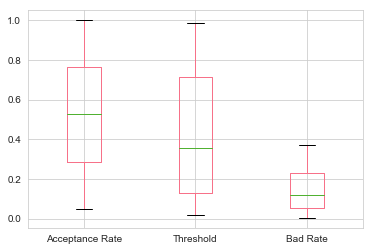

In [260]:
strat_df.boxplot()
plt.show()

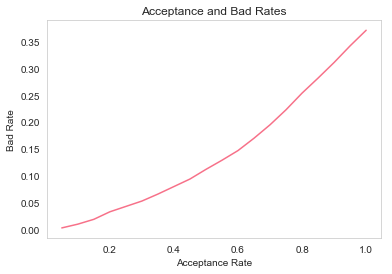

In [262]:
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()